In [1]:
import os
import random
import itertools
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader, Subset, ConcatDataset
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
%matplotlib inline

In [2]:
from time import time
import torchvision.transforms as transforms

In [3]:
from datetime import datetime

In [4]:
#pip install -U scikit-learn

In [5]:
#pip install kaggle --quiet

In [6]:
DATA_DIR = 'C:/Dataset/NWPURESISC_45/'

TRAIN_DIR = DATA_DIR + '/train'
TEST_DIR = DATA_DIR + '/test'

#PRED_DIR = DATA_DIR + '/Pred'

In [7]:
classes = os.listdir(TRAIN_DIR)
classes

['airplane',
 'airport',
 'baseball_diamond',
 'basketball_court',
 'beach',
 'bridge',
 'chaparral',
 'church',
 'circular_farmland',
 'cloud',
 'commercial_area',
 'dense_residential',
 'desert',
 'forest',
 'freeway',
 'golf_course',
 'ground_track_field',
 'harbor',
 'industrial_area',
 'intersection',
 'island',
 'lake',
 'meadow',
 'medium_residential',
 'mobile_home_park',
 'mountain',
 'overpass',
 'palace',
 'parking_lot',
 'railway',
 'railway_station',
 'rectangular_farmland',
 'river',
 'roundabout',
 'runway',
 'sea_ice',
 'ship',
 'snowberg',
 'sparse_residential',
 'stadium',
 'storage_tank',
 'tennis_court',
 'terrace',
 'thermal_power_station',
 'wetland']

In [8]:
print('TRAIN')
for label in classes:
    files = os.listdir('{}/{}'.format(TRAIN_DIR, label))
    print('{} {} \t {}'.format(len(files), label, files[:3]))

print()
print('TEST')
for label in classes:
    files = os.listdir('{}/{}'.format(TEST_DIR, label))
    print('{} {} \t {}'.format(len(files), label, files[:3]))

TRAIN
600 airplane 	 ['airplane_001.jpg', 'airplane_002.jpg', 'airplane_003.jpg']
600 airport 	 ['airport_001.jpg', 'airport_002.jpg', 'airport_003.jpg']
600 baseball_diamond 	 ['baseball_diamond_001.jpg', 'baseball_diamond_002.jpg', 'baseball_diamond_003.jpg']
600 basketball_court 	 ['basketball_court_001.jpg', 'basketball_court_002.jpg', 'basketball_court_003.jpg']
600 beach 	 ['beach_001.jpg', 'beach_002.jpg', 'beach_003.jpg']
600 bridge 	 ['bridge_001.jpg', 'bridge_002.jpg', 'bridge_003.jpg']
600 chaparral 	 ['chaparral_001.jpg', 'chaparral_002.jpg', 'chaparral_003.jpg']
600 church 	 ['church_001.jpg', 'church_002.jpg', 'church_003.jpg']
600 circular_farmland 	 ['circular_farmland_001.jpg', 'circular_farmland_002.jpg', 'circular_farmland_003.jpg']
600 cloud 	 ['cloud_001.jpg', 'cloud_002.jpg', 'cloud_003.jpg']
600 commercial_area 	 ['commercial_area_001.jpg', 'commercial_area_002.jpg', 'commercial_area_003.jpg']
600 dense_residential 	 ['dense_residential_001.jpg', 'dense_residenti

In [9]:
import torchvision.transforms as T
def _my_normalization(x):
    return x + (0.01**0.5)*torch.randn(x.shape)


transform = T.Compose([
T.Pad(16), # Use 8 or 16 for 256 data
T.RandomRotation([-5,5]), # Start here, increas
T.Resize(256),
T.RandomCrop(256),
T.ColorJitter(brightness=0.5,contrast=0.5, saturation=0.5),    
T.ToTensor(),
])

train_dataset = ImageFolder(TRAIN_DIR, transform=transform)
test_dataset = ImageFolder(TEST_DIR, transform=transform)


len(train_dataset), len(test_dataset)

(27000, 4500)

In [10]:
img, label = train_dataset[0]
print(img.shape, label)


torch.Size([3, 256, 256]) 0


In [12]:
classes = train_dataset.classes
classes

['airplane',
 'airport',
 'baseball_diamond',
 'basketball_court',
 'beach',
 'bridge',
 'chaparral',
 'church',
 'circular_farmland',
 'cloud',
 'commercial_area',
 'dense_residential',
 'desert',
 'forest',
 'freeway',
 'golf_course',
 'ground_track_field',
 'harbor',
 'industrial_area',
 'intersection',
 'island',
 'lake',
 'meadow',
 'medium_residential',
 'mobile_home_park',
 'mountain',
 'overpass',
 'palace',
 'parking_lot',
 'railway',
 'railway_station',
 'rectangular_farmland',
 'river',
 'roundabout',
 'runway',
 'sea_ice',
 'ship',
 'snowberg',
 'sparse_residential',
 'stadium',
 'storage_tank',
 'tennis_court',
 'terrace',
 'thermal_power_station',
 'wetland']

In [13]:
def show_sample(img, label):
    plt.title('Label: {}, ({})'.format(classes[label], label))
    plt.imshow(img.permute(1, 2, 0))

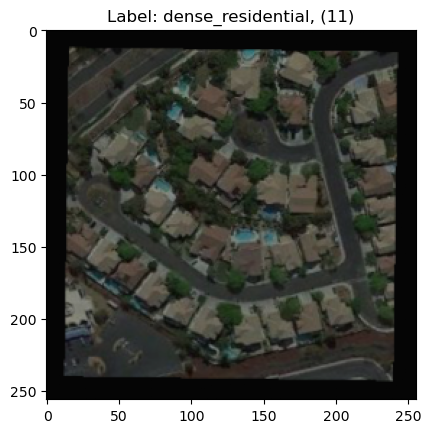

In [14]:
index = random.randrange(len(train_dataset))
show_sample(*train_dataset[index])

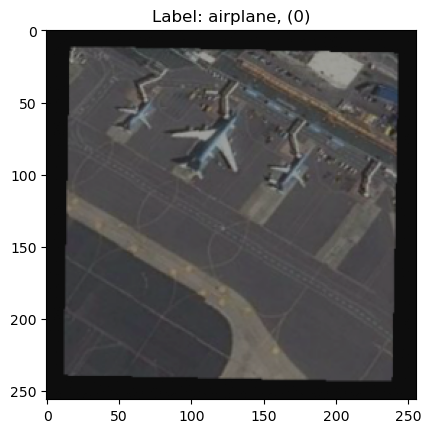

In [15]:
index = random.randrange(len(train_dataset))
show_sample(*train_dataset[index])

In [16]:
random_seed = 42
torch.manual_seed(random_seed)

In [17]:
train_subset = train_dataset
test_subset = test_dataset
len(train_subset), len(test_subset)

(27000, 4500)

In [18]:
val_size = int(len(test_subset) * 0.5)
test_size = len(test_subset) - val_size

test_subset, val_subset = random_split(test_subset, [test_size, val_size])
len(train_subset), len(val_subset), len(test_subset)

(27000, 2250, 2250)

In [19]:
batch_size=64

In [20]:
train_dataloader = DataLoader(train_subset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_subset, batch_size*2, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_subset, batch_size*2, num_workers=4, pin_memory=True)

In [21]:
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0))
        break

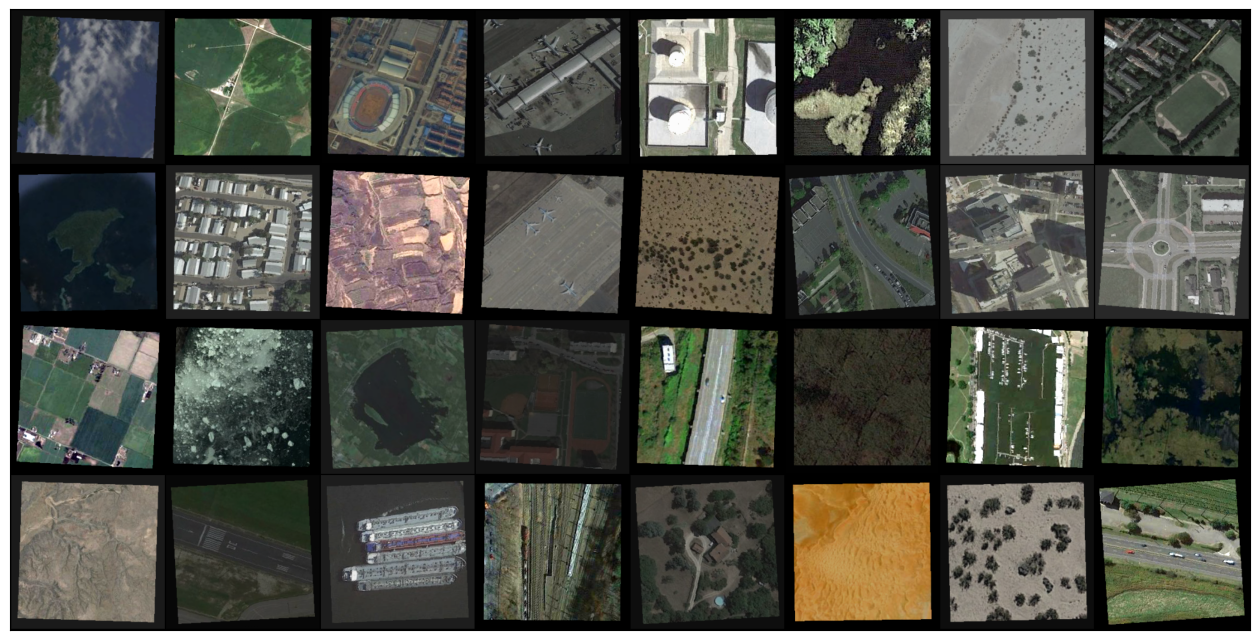

In [22]:
show_batch(train_dataloader)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [24]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def Train(epoch, print_every=50):
    total_loss = 0
    start_time = time()
    
    accuracy = []
    
    for i, batch in enumerate(train_dataloader, 1):
        minput = batch[0] # Get batch of images from our train dataloader
        target = batch[1] # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
        minput, target = minput.to(device), target.to(device)
        
        moutput = model(minput) # output by our model
        
        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters
        scheduler.step()
        
        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time 
            ))
    
    return total_loss / len(train_dataloader) # Returning Average Training Loss

def Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []
    
    with  torch.inference_mode(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(val_dataloader):
            minput = batch[0] # Get batch of images from our test dataloader
            target = batch[1] # Get the corresponding target(0, 1 or 2) representing classes
            minput, target = minput.to(device), target.to(device)
            
            moutput = model(minput) # output by our model

            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()
            
            
            # To get the probabilities for different classes we need to apply a softmax operation on moutput 
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets
            
    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(val_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return total_loss/len(val_dataloader) # Returning Average Testing Loss

In [ ]:
import torch


from models.MHCCT import CCT          ################# To use MSHCCT

model = CCT(
    img_size = (256, 256),
    embedding_dim = 64,
    n_conv_layers = 2,
    kernel_size = 7,
    stride = 2,
    padding = 3,
    pooling_kernel_size = 3,
    pooling_stride = 2,
    pooling_padding = 1,
    num_layers = 1,
    num_heads = 2,
    mlp_ratio = 3.,
    num_classes = 45,
    positional_embedding = 'learnable', # ['sine', 'learnable', 'none']
).to(device)

from torchsummary import summary
summary(model, (3,256,256))

In [28]:
from models.CosineScheduler import CosineScheduler

lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(label_smoothing=0.5)

nepochs = 50
warmup=5
linear_wi=True
scheduler = CosineScheduler(optimizer,total_epochs=nepochs,
                            warmup=warmup,
                            linear_wu=linear_wi)

In [ ]:
Test(0)

train_loss = []
test_loss = []
start_time = datetime.now()
# do your work here

for epoch in range(1, 50):
    
    
    train_loss.append(Train(epoch,100))
    test_loss.append(Test(epoch))

    print('\n')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))       

In [42]:
torch.save(model.state_dict(), 'MSCCT_Hyper_classifier_AID.pth')

In [32]:
@torch.no_grad()
def predictions(model, dataloader):
    torch.cuda.empty_cache()
    preds_list = torch.zeros(0, dtype=torch.long, device=device)
    labels_list = torch.zeros(0, dtype=torch.long, device=device)
    for i, batch in enumerate(dataloader):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds  = torch.max(outputs, dim=1)
        preds_list = torch.cat((preds_list, preds), 0)
        labels_list = torch.cat((labels_list, labels), 0)
    return preds_list, labels_list

In [33]:
preds_list, labels_list = predictions(model, test_dataloader)
#preds_list, labels_list

In [34]:
matrix = torch.zeros(len(classes), len(classes), dtype=torch.int64)
for i in range(len(preds_list)):
    matrix[preds_list[i], labels_list[i]] += 1
matrix

tensor([[46,  0,  0,  ...,  1,  0,  0],
        [ 1, 27,  0,  ...,  0,  0,  0],
        [ 0,  0, 41,  ...,  0,  0,  0],
        ...,
        [ 0,  1,  0,  ..., 43,  1,  0],
        [ 0,  1,  0,  ...,  0, 44,  0],
        [ 0,  0,  0,  ...,  0,  1, 46]])

In [38]:
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score

In [ ]:
preds_list, labels_list = predictions(model, test_dataloader)
preds_list, labels_list

SAVE_PATH='C:/Results/'

## classfication report
test_pred = preds_list.cpu()
test_true = labels_list.cpu()

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
#report_log += f"training time: {train_time}\ninferring time: {infer_time}\n"
report_log += classification_report(test_true,test_pred,target_names=classes,digits=4)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'MSHCCT_Hyper_classfication_report.txt'),'w+')
fp.writelines(report_log)
fp.close()